In [2]:
! pip install findspark

In [22]:
# setup init
import findspark
findspark.init()

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


from pyspark.sql import SparkSession
import pyspark.sql.functions as F

import os

In [4]:
spark = SparkSession.builder.appName('spark_training').getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

spark

In [11]:
tips = spark.read.csv('../data/tips.csv', header=True, inferSchema=True)

tips.show(2, False)

+----------+----+--------+------+---+------+----+
|total_bill|tip |location|smoker|day|time  |size|
+----------+----+--------+------+---+------+----+
|16.99     |1.01|urban   |No    |Sun|Dinner|2   |
|10.34     |1.66|rural   |No    |Sun|Dinner|3   |
+----------+----+--------+------+---+------+----+
only showing top 2 rows



In [12]:
tips.printSchema()

root
 |-- total_bill: double (nullable = true)
 |-- tip: double (nullable = true)
 |-- location: string (nullable = true)
 |-- smoker: string (nullable = true)
 |-- day: string (nullable = true)
 |-- time: string (nullable = true)
 |-- size: integer (nullable = true)



In [13]:
tips.limit(5).show()

+----------+----+--------+------+---+------+----+
|total_bill| tip|location|smoker|day|  time|size|
+----------+----+--------+------+---+------+----+
|     16.99|1.01|   urban|    No|Sun|Dinner|   2|
|     10.34|1.66|   rural|    No|Sun|Dinner|   3|
|     21.01| 3.5|   rural|    No|Sun|Dinner|   3|
|     23.68|3.31|   rural|    No|Sun|Dinner|   2|
|     24.59|3.61|   urban|    No|Sun|Dinner|   4|
+----------+----+--------+------+---+------+----+



In [14]:
tips.limit(5).toPandas()

,total_bill,tip,location,smoker,day,time,size
0,16.99,1.01,urban,No,Sun,Dinner,2
1,10.34,1.66,rural,No,Sun,Dinner,3
2,21.01,3.50,rural,No,Sun,Dinner,3
3,23.68,3.31,rural,No,Sun,Dinner,2
4,24.59,3.61,urban,No,Sun,Dinner,4


In [16]:
tips.describe().show()

+-------+------------------+------------------+--------+------+----+------+------------------+
|summary|        total_bill|               tip|location|smoker| day|  time|              size|
+-------+------------------+------------------+--------+------+----+------+------------------+
|  count|               244|               244|     244|   244| 244|   244|               244|
|   mean|19.785942622950824|2.9982786885245902|    null|  null|null|  null| 2.569672131147541|
| stddev| 8.902411954856857|1.3836381890011815|    null|  null|null|  null|0.9510998047322347|
|    min|              3.07|               1.0|   rural|    No| Fri|Dinner|                 1|
|    max|             50.81|              10.0|   urban|   Yes|Thur| Lunch|                 6|
+-------+------------------+------------------+--------+------+----+------+------------------+



In [18]:
tips.describe().select('summary', 'tip').show()

+-------+------------------+
|summary|               tip|
+-------+------------------+
|  count|               244|
|   mean|2.9982786885245902|
| stddev|1.3836381890011815|
|    min|               1.0|
|    max|              10.0|
+-------+------------------+



In [28]:
tips \
.select('tip') \
.approxQuantile('tip', [0.0, 0.33, 0.66, 1.0], relativeError=0.0)

[1.0, 2.02, 3.25, 10.0]

In [31]:
only_rural = tips.where(F.col('location') == 'rural')

In [32]:
only_rural.count()

157

In [33]:
only_rural.describe().select('summary', 'tip').show()

+-------+------------------+
|summary|               tip|
+-------+------------------+
|  count|               157|
|   mean|3.0896178343949052|
| stddev| 1.489101813842018|
|    min|               1.0|
|    max|              10.0|
+-------+------------------+



In [35]:
only_urban = tips.where(F.col('location') == 'urban')

only_urban.count()

87

In [36]:
only_urban.describe().select('summary', 'tip').show()

+-------+------------------+
|summary|               tip|
+-------+------------------+
|  count|                87|
|   mean| 2.833448275862069|
| stddev|1.1594945045210152|
|    min|               1.0|
|    max|               6.5|
+-------+------------------+



In [40]:
only_rural.agg({
    'tip': 'avg',
}).show()

only_urban.agg({
    'tip': 'avg',
}).show()

+------------------+
|          avg(tip)|
+------------------+
|3.0896178343949052|
+------------------+

+-----------------+
|         avg(tip)|
+-----------------+
|2.833448275862069|
+-----------------+



In [42]:
group_by_cols = ['location', 'smoker', 'day', 'time', 'size']

In [43]:
for c in group_by_cols:
    tips.groupBy(c).avg('tip').show()

+--------+------------------+
|location|          avg(tip)|
+--------+------------------+
|   rural|3.0896178343949052|
|   urban| 2.833448275862069|
+--------+------------------+

+------+------------------+
|smoker|          avg(tip)|
+------+------------------+
|    No|2.9918543046357624|
|   Yes| 3.008709677419355|
+------+------------------+

+----+-----------------+
| day|         avg(tip)|
+----+-----------------+
|Thur|2.771451612903226|
| Sun|3.255131578947369|
| Sat|2.993103448275862|
| Fri|2.734736842105263|
+----+-----------------+

+------+------------------+
|  time|          avg(tip)|
+------+------------------+
| Lunch|2.7280882352941176|
|Dinner| 3.102670454545454|
+------+------------------+

+----+------------------+
|size|          avg(tip)|
+----+------------------+
|   1|            1.4375|
|   6|             5.225|
|   3| 3.393157894736842|
|   5|4.0280000000000005|
|   4| 4.135405405405407|
|   2| 2.582307692307693|
+----+------------------+



In [45]:
tips \
.withColumn('log_tip', F.log(tips['tip'])) \
.select('tip', 'log_tip').show(5, False)

+----+--------------------+
|tip |log_tip             |
+----+--------------------+
|1.01|0.009950330853168092|
|1.66|0.5068176023684519  |
|3.5 |1.252762968495368   |
|3.31|1.1969481893889715  |
|3.61|1.2837077723447896  |
+----+--------------------+
only showing top 5 rows



In [52]:
max_tip = tips.select(F.max('tip').alias('max_tip')).collect()[0].max_tip

In [56]:
tips = tips \
.withColumn('tip_pct', F.col('tip') / max_tip) 

tips\
.select('tip', 'tip_pct').show()

+----+-------------------+
| tip|            tip_pct|
+----+-------------------+
|1.01|              0.101|
|1.66|0.16599999999999998|
| 3.5|               0.35|
|3.31|              0.331|
|3.61|              0.361|
|4.71|              0.471|
| 2.0|                0.2|
|3.12|              0.312|
|1.96|              0.196|
|3.23|              0.323|
|1.71|0.17099999999999999|
| 5.0|                0.5|
|1.57|              0.157|
| 3.0|                0.3|
|3.02|              0.302|
|3.92|              0.392|
|1.67|0.16699999999999998|
|3.71|              0.371|
| 3.5|               0.35|
|3.35|              0.335|
+----+-------------------+
only showing top 20 rows



In [57]:
for c in group_by_cols:
    tips.groupBy(c).avg('tip_pct').show()

+--------+------------------+
|location|      avg(tip_pct)|
+--------+------------------+
|   rural|0.3089617834394903|
|   urban|0.2833448275862068|
+--------+------------------+

+------+-------------------+
|smoker|       avg(tip_pct)|
+------+-------------------+
|    No|0.29918543046357615|
|   Yes|0.30087096774193534|
+------+-------------------+

+----+-------------------+
| day|       avg(tip_pct)|
+----+-------------------+
|Thur| 0.2771451612903225|
| Sun|0.32551315789473667|
| Sat|0.29931034482758606|
| Fri|0.27347368421052637|
+----+-------------------+

+------+------------------+
|  time|      avg(tip_pct)|
+------+------------------+
| Lunch|0.2728088235294117|
|Dinner|0.3102670454545454|
+------+------------------+

+----+-------------------+
|size|       avg(tip_pct)|
+----+-------------------+
|   1|            0.14375|
|   6|             0.5225|
|   3| 0.3393157894736843|
|   5|0.40279999999999994|
|   4|0.41354054054054057|
|   2|  0.258230769230769|
+----+---------

<AxesSubplot: >

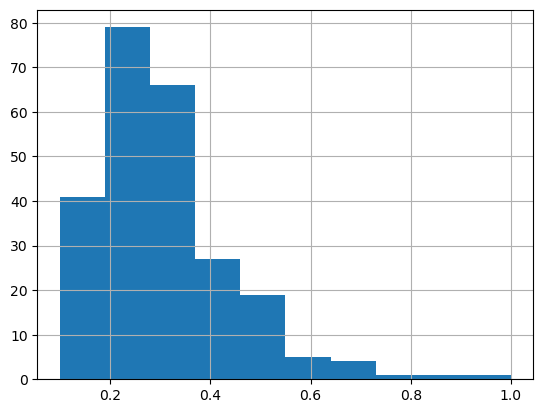

In [61]:
tips\
.select('tip', 'tip_pct').toPandas()['tip_pct'].hist()